In [1]:
import pandas as pd
import json
import numpy as np
import time 
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating text-based similarity

#### Import and Transform Data Products Metadata

In [ ]:
start_time = time.time()

In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_meta_Cell_Phones_and_Accessories", split="full", trust_remote_code=True)
print(dataset[0])

Algunos features que podemos utilizar para la categoria de Cell phones and Accesories:

details > Product Dimensions  > lenght , width ,height 
details > Item Weight  
details > Color
categories > 
Compatible Phone Models > "Check if there are standar models"
Material > separeate by comma
Screen Size > 5.7
price

The weight is on onces, the dimensions are in inches

We will use id product to differentiate between them

In [ ]:
products = []
# products_df = pd.DataFrame()

for product in dataset:

    product_details = json.loads(product['details'])

    aux_product = {}
    aux_product['id'] = product['parent_asin']

    #Que tengan un titulo similar 
    aux_product['title'] = product['title']


    if 'Item Weight' in product_details.keys():
        #Que tengan un peso similar
        aux_product['weight'] = product_details['Item Weight'].split(' ')[0] or -1

    #Que tengan una categoria similar 
    aux_cat = ''
    #Add any categories that the product has, limited by 3
    for i,cat in enumerate(product['categories']):
        aux_cat += cat + ','
    aux_product[f"categorie"] = aux_cat
    
    aux_compatible = ''
    if 'Compatible Phone Models' in product_details.keys():
        for i,model in enumerate(product_details['Compatible Phone Models'].split(',')):
            # We only get the first 5 compatible phones
            aux_compatible += model + ','

    aux_product[f"compatible"] = aux_compatible

    aux_material = ''
    if 'Material' in product_details.keys():
        
        for i,material in enumerate(product_details['Material'].split(',')):
            aux_material += material + ','
        
    aux_product[f"material"] = aux_material

    aux_product['price'] = product['price'] or -1
    
    # Que tengan descripcion similar
    aux_product["description"] = product['description'] or np.nan

    aux_product["features"] = product['features'] or np.nan

    if len(product['images']['large']) > 0:
        aux_product["img"] = product['images']['large'][0] or np.nan
    else:
        aux_product["img"] = ''
        
    aux_product['avg_rating'] = product['average_rating'] or np.nan

    aux_product['url'] = 'https://amazon.com.mx/' + product['parent_asin']

    products.append(aux_product)


len(products)

1288490

In [ ]:
products_df = pd.DataFrame(products)
products_df.replace('', np.nan, inplace=True)


In [174]:
# Use this line to create the products dataframe and reduced the time to obtain the data to work with
products_df.to_csv('./products_cleaned.csv',index=False)

In [ ]:
end_time = time.time()

In [ ]:
total_time_transform_data = end_time - start_time

#### With Pandas and Sklearn

In [3]:
start_time = time.time()

Let's make a content-based recommender by the compability of phones

1.  First we're gonna create a dataframe based on our cleaned and tranform products

In [2]:
products_df = pd.read_csv('./products_cleaned.csv')
products_df.head(5)

,id,title,weight,categorie,compatible,material,price,description,features,img,avg_rating,url
0,B013SK1JTY,ARAREE Slim Diary Cell Phone Case for Samsung ...,2.68,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy Note, Samsung Galaxy Note 5,","Leather, Polycarbonate,",NaN,"[""JUST LOOK, You can tell the difference. Make...",['Genuine Cow leather with 6 different colors'...,https://m.media-amazon.com/images/I/51Q9w96zIQ...,3.8,https://amazon.com.mx/B013SK1JTY
1,B07ZPSG8P5,Bastmei for OnePlus 7T Case Extremely Light Ul...,1.44,"Cell Phones & Accessories,Cases, Holsters & Sl...","OnePlus 7T,","Polycarbonate,",11.98,NaN,['Ultra-thin & Ultra-light: The ultra slim fit...,https://m.media-amazon.com/images/I/41Mo5IIOw6...,4.4,https://amazon.com.mx/B07ZPSG8P5
2,B00GKR3L12,Wireless Fones Branded New Iphone 5C/LITE Hot ...,NaN,"Cell Phones & Accessories,iPhone Accessories,",NaN,NaN,NaN,NaN,NaN,https://m.media-amazon.com/images/I/51qqm0cG4V...,4.0,https://amazon.com.mx/B00GKR3L12
3,B00PB8U8BW,"iPhone 6 Plus + Case, DandyCase Perfect PATTER...",0.80,"Cell Phones & Accessories,iPhone Accessories,","iPhone 6 Plus,","TPU,",NaN,['Case does not need to be removed for chargin...,"['Slim-Fit design for the iPhone 6 Plus (5.5"" ...",https://m.media-amazon.com/images/I/51DIzvm4V3...,4.0,https://amazon.com.mx/B00PB8U8BW
4,B07D3RHSRV,"Case for Galaxy S6/S6 Edge, Thin Translucent V...",2.92,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy S6,","Faux Leather, Polycarbonate,",NaN,NaN,NaN,https://m.media-amazon.com/images/I/11B94nE+l4...,4.0,https://amazon.com.mx/B07D3RHSRV


Once we got our products in a DataFrame, we will remove the rows which don't have data in the column `compatible`

In [3]:
products_clean_compatible_df = products_df.copy()
products_clean_material_df = products_df.copy()

products_clean_compatible_df.dropna(subset=['compatible'], inplace=True)
products_clean_material_df.dropna(subset=['material'], inplace=True)
products_clean_compatible_df.head()

,id,title,weight,categorie,compatible,material,price,description,features,img,avg_rating,url
0,B013SK1JTY,ARAREE Slim Diary Cell Phone Case for Samsung ...,2.68,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy Note, Samsung Galaxy Note 5,","Leather, Polycarbonate,",NaN,"[""JUST LOOK, You can tell the difference. Make...",['Genuine Cow leather with 6 different colors'...,https://m.media-amazon.com/images/I/51Q9w96zIQ...,3.8,https://amazon.com.mx/B013SK1JTY
1,B07ZPSG8P5,Bastmei for OnePlus 7T Case Extremely Light Ul...,1.44,"Cell Phones & Accessories,Cases, Holsters & Sl...","OnePlus 7T,","Polycarbonate,",11.98,NaN,['Ultra-thin & Ultra-light: The ultra slim fit...,https://m.media-amazon.com/images/I/41Mo5IIOw6...,4.4,https://amazon.com.mx/B07ZPSG8P5
3,B00PB8U8BW,"iPhone 6 Plus + Case, DandyCase Perfect PATTER...",0.80,"Cell Phones & Accessories,iPhone Accessories,","iPhone 6 Plus,","TPU,",NaN,['Case does not need to be removed for chargin...,"['Slim-Fit design for the iPhone 6 Plus (5.5"" ...",https://m.media-amazon.com/images/I/51DIzvm4V3...,4.0,https://amazon.com.mx/B00PB8U8BW
4,B07D3RHSRV,"Case for Galaxy S6/S6 Edge, Thin Translucent V...",2.92,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy S6,","Faux Leather, Polycarbonate,",NaN,NaN,NaN,https://m.media-amazon.com/images/I/11B94nE+l4...,4.0,https://amazon.com.mx/B07D3RHSRV
6,B0BHY2CR5B,"iMangoo Galaxy S22 Case, for Samsung Galaxy S2...",1.44,"Cell Phones & Accessories,Cases, Holsters & Sl...","Samsung Galaxy S22,","Faux Leather,",11.99,NaN,['Compatibility: This Galaxy S22 case is only ...,https://m.media-amazon.com/images/I/51nZu7lnhH...,4.5,https://amazon.com.mx/B0BHY2CR5B


Now we're gonna calculate the similarity of `compatible` column, for that we're going to create a TF-IDF("Term Frequency Inverse Document Frequency") vectorizer `TfidfVectorizer()` 

TF-IDF divides the number of times a word occurs in a document by a measure of what proportion of all the documents a word occurs in. 

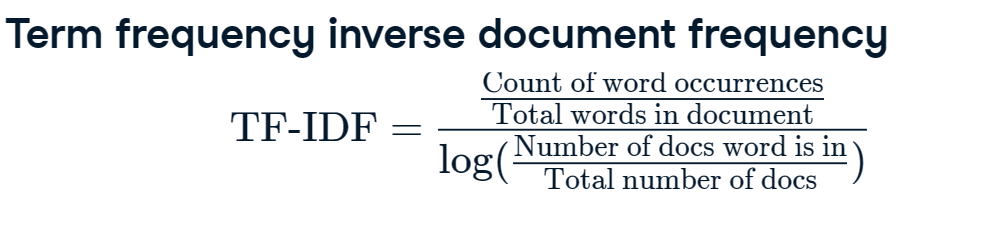

First, we set the min_df argument to two. This limits our features to only those that have occurred in at least two documents. Useful as terms occurring once are not valuable for finding similarities.

We should also remove words that are too common using max_df. By setting this to point seven, words that occur in more than 70% of the descriptions will be excluded.

`vectorized_descriptions` is a NxM dimension array, where N is the number of items and M the number of features

`tfid.get_feature_names_out()` shows the features that our vectorizer gets

In [5]:

tfid = TfidfVectorizer(min_df=10,max_df=0.7)
vectorized_descriptions = tfid.fit_transform(products_clean_compatible_df['compatible'])
features = tfid.get_feature_names_out()
data_vectorized = vectorized_descriptions.toarray()

#Make a dataframe with features and data

tfidf_df = pd.DataFrame(data_vectorized,columns=features,index=products_clean_compatible_df['id'])

tfidf_df.head()

,05e,10,1020,10e,10ft,10l,10pro,10r,10s,10t,...,zero,zfive,zmax,zone,zoom,zte,zuk,𝐌𝐚𝐱,𝐏𝐫𝐨,𝐢𝐏𝐡𝐨𝐧𝐞
id,,,,,,,,,,,,,,,,,,,,,
B013SK1JTY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B07ZPSG8P5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00PB8U8BW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B07D3RHSRV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0BHY2CR5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use cosine similarity to find the similarity between two items or all items

In [6]:
cosine_similarity_array = cosine_similarity(tfidf_df)


cosine_similarity_df = pd.DataFrame(cosine_similarity_array,columns=products_clean_compatible_df['id'],index=products_clean_compatible_df['id'])
display(cosine_similarity_df.head())

Now we have our dataframe we can make queries about a product, for example: 

> Supose that we are searching for a samsung galaxy S6 case. Now our recommender engine will show the top 5 products that have the most similarity. our current product is `B07D3RHSRV`

In [ ]:
recomendations = cosine_similarity_df.loc['B07D3RHSRV'].sort_values(ascending=False)
top5_recomendations = recomendations.iloc[1:6]  # Exclude the first one (self-similarity)

#join our recomendations with our original data
recomendation_products = products_df[['title','description','img','avg_rating','url']][products_df['id'].isin(top5_recomendations.index)]

#Create the return array use, to json when we are exporting it
return_array = recomendation_products.to_dict(orient='records')


At this point, we can return different objects, suppose that we are working on a e-commerce, we will return data, that can be painted in a interface like this:

Our goal is return a json object 


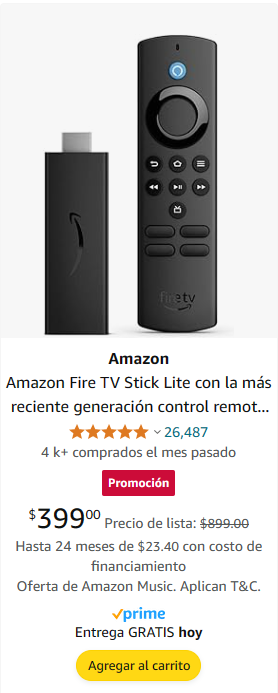

In [ ]:
end_time = time.time()

In [ ]:
total_time_content_based_pandas = end_time - start_time

#### With PySpark

## Creating user profiles

We will create user profiles based on what items did they bought based on verification reviews

#### Import and Transform Data

In [ ]:
start_time = time.time()

In [22]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_review_Cell_Phones_and_Accessories", split="full", trust_remote_code=True)
print(dataset[0])

{'rating': 4.0, 'title': 'No white background! It’s clear!', 'text': 'I bought this bc I thought it had the nice white background. Turns out it’s clear & since my phone is blue it doesn’t look anything like this.  If I had known that I would have purchased something else. It works ok.', 'images': [{'attachment_type': 'IMAGE', 'large_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL1600_.jpg', 'medium_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL800_.jpg', 'small_image_url': 'https://images-na.ssl-images-amazon.com/images/I/B1PrCo7ZjXS._SL256_.jpg'}], 'asin': 'B08L6L3X1S', 'parent_asin': 'B08L6L3X1S', 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ', 'timestamp': 1612044451196, 'helpful_vote': 0, 'verified_purchase': True}


Algunos features que podemos utilizar para la categoria de Cell phones and Accesories:

details > Product Dimensions  > lenght , width ,height 
details > Item Weight  
details > Color
categories > 
Compatible Phone Models > "Check if there are standar models"
Material > separeate by comma
Screen Size > 5.7
price

The weight is on onces, the dimensions are in inches

We will use id product to differentiate between them

This dataset is around 9

In [26]:
reviews = []
# products_df = pd.DataFrame()
i = 0
for review in dataset:
    if i > 1288490:
        break

    if review['verified_purchase'] is True:
        aux_review = {}
        aux_review['rating'] = review['rating']

        #Que tengan un titulo similar 
        aux_review['title'] = review['title']

        #Analisis de sentimientos o reviews parecidas
        aux_review['text'] = review['text']

        #Producto asociado recomendar productos no comprados
        aux_review['id_product'] = review['parent_asin']

        #Producto asociado
        aux_review['id_user'] = review['user_id']

        #Compra verificada
        aux_review['verified_purchase'] = review['verified_purchase']

        aux_review['helpful_vote'] = review['helpful_vote']


        aux_review['url'] = 'https://amazon.com.mx/' + review['parent_asin']

        reviews.append(aux_review)

    i += 1

len(reviews)

1211278

In [27]:
reviews_df = pd.DataFrame(reviews)
reviews_df.replace('', np.nan, inplace=True)


In [28]:
# Use this line to create the products dataframe and reduced the time to obtain the data to work with
reviews_df.to_csv('./reviews_cleaned.csv',index=False)

In [ ]:
end_time = time.time()

In [ ]:
total_time_transform_data_reviews  = end_time - start_time

#### With Pandas and Sklearn

In [3]:
start_time = time.time()

In [29]:
reviews_df = pd.read_csv('./reviews_cleaned.csv')
reviews_df.head(5)

,rating,title,text,id_product,id_user,verified_purchase,helpful_vote,url
0,4.0,No white background! It’s clear!,I bought this bc I thought it had the nice whi...,B08L6L3X1S,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,True,0,https://amazon.com.mx/B08L6L3X1S
1,5.0,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...,B079BPGF6C,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,True,2,https://amazon.com.mx/B079BPGF6C
2,5.0,Worked but took an hour to install,Overall very happy with the end result. If you...,B0BBGGC8F2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,True,3,https://amazon.com.mx/B0BBGGC8F2
3,4.0,Decent,Lasted about 9 months then the lock button bro...,B07XRDHDNQ,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,True,0,https://amazon.com.mx/B07XRDHDNQ
4,5.0,LOVE IT!,LOVE THIS CASE! Works better than my expensive...,B00A8ZDL9Y,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,True,0,https://amazon.com.mx/B00A8ZDL9Y


We need to extract for each user which the products bought

In [30]:
# Extract products bought by each user
products_bought_by_user = reviews_df.groupby('id_user')['id_product'].unique().reset_index()

For example we want to recommend products for a user with more than 5 products bought

In [ ]:
# Filter users who bought more than 5 products
products_from_user = products_bought_by_user[products_bought_by_user['id_product'].apply(len) > 5]
# Apply the funcion len() to know how many products bought each user 
products_from_user.loc[:,'id_product'] = products_from_user['id_product'].apply(len)
# Order users by who bought more products
products_from_user = products_from_user.sort_values(by='id_product', ascending=False)['id_product'].index[0]

# Obtain the products of the user who bought more products
products_from_user_to_recommend = products_bought_by_user['id_product'].loc[products_from_user]
products_from_user_to_recommend

Now we're going to create a user profile, which allows us to recommend products based on those that haven't been bought yet and have strong similarity.

So we have to load our TF-IDF dataframe from our content based recommender engine

In [60]:
products_bought = tfidf_df.reindex(products_from_user_to_recommend)

#Remove products that are not in the tfidf dataframe
products_bought.dropna(inplace=True)

# Generate the user profile by finding the average scores of products they bought
user_prof = products_bought.mean()

# Find subset of tfidf_df that does not products in products_from_user_to_recommend
tfidf_subset_df = tfidf_df.drop(tfidf_df.index.intersection(products_from_user_to_recommend))

# Calculate the cosine_similarity and wrap it in a DataFrame
similarity_array = cosine_similarity(user_prof.values.reshape(1, -1), tfidf_subset_df)
similarity_df = pd.DataFrame(similarity_array.T, index=tfidf_subset_df.index, columns=["similarity_score"])


# Sort the values from high to low by the values in the similarity_score
sorted_similarity_df = similarity_df.sort_values(by="similarity_score", ascending=False)

# Inspect the most similar to the user preferences
sorted_similarity_df.head()

,similarity_score
id,
B09QHH7N57,0.918064
B0C3VQ1CN4,0.917429
B09BNC3VVT,0.917359
B08V4ZG17J,0.908112
B0C2GN8Y3Y,0.906189


Now we can recommend 10 products to a user based on the products they've bought.

In [63]:
top5_recomendations = sorted_similarity_df.iloc[0:5] 

#join our recomendations with our original data
recomendation_products_user_profile = products_df[['title','description','img','avg_rating','url']][products_df['id'].isin(top5_recomendations.index)]

#Create the return array use, to json when we are exporting it
return_array_user_profile = recomendation_products_user_profile.to_dict(orient='records')

return_array_user_profile

[{'title': 'Easycosy Personalized Picture Phone Cases for 14 13 12 11 Pro/Max/Mini XR X Xs Max Custom Multiple Photo iPhone Case for Friends Family Birthday Gifts Customized Full Protection TPU Cover',
  'description': nan,
  'img': 'https://m.media-amazon.com/images/I/51xrFK8JBrL._AC_.jpg',
  'avg_rating': 4.4,
  'url': 'https://amazon.com.mx/B0C3VQ1CN4'},
 {'title': 'Quezqa Wireless Charging Station - 3 in 1 Fast Wireless Charger – Qi Fast Charging Dock for AirPods Pro 3 2 Apple Watch Ultra 8 7 SE 6 5 4 iPhone 14 Pro Max 14 Plus 13 12 11 Pro Max with QC Adapter',
  'description': nan,
  'img': 'https://m.media-amazon.com/images/I/41Od0hQStXL._AC_.jpg',
  'avg_rating': 4.0,
  'url': 'https://amazon.com.mx/B08V4ZG17J'},
 {'title': 'AFLYDOG Charging Station for Apple Multiple Devices, Adjustable 3 in 1 Charging Stand Dock Holder Foldable Charger Stand Compatible with Apple Watch SE/8/7/6/5/4/3/2/1 iPhone AirPods',
  'description': nan,
  'img': 'https://m.media-amazon.com/images/I/41SPk